# Customer Segmentation for an Online Store using K-Means and Hierarchial Clustering - Ganesh Shetty

**Overview**<br>
<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail is a transnational data set</a> which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers. We need to perform Customer Segmentation

## 1. Importing and Checking the Data

In [1]:
# Importing all important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#Loading Dataset
df=pd.read_csv("Online_Retail.csv", sep=",", encoding="ISO-8859-1", header=0)

In [3]:
#First few lines of Dataset
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [4]:
#Information Summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


We can see that there are some missing values in the data. Lets check the % missing values and explore the ways to treat them.

## 2. Cleaning the Data

In [5]:
# Percentage of missing values
round(df.isnull().sum()/len(df)*100,2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

Less than 1 % of Description is missing. And we have a dataset of half million entries. We can conviniently ignore this and drop the missing information

We can also observe that ~25% of CustomerID's are missing. CustomerID's are important information when we are creating segmentation. Since we can not treat customerID's in any better way we will drop this from our analysis

In [6]:
#Dropping the missing information from Dataset
df=df.dropna()

In [7]:
# Percentage of missing values
round(df.isnull().sum()/len(df)*100,2)

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

In [8]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


For segmentation Quantity and UnitPrice will not give a good picture as people may buy
- cheaper items (Low UnitPrice) in large Quantity
- expensive items (high UnitPrice) in small Quantity

Better way to deal with this is by converting the Quantity and UnitPrice to total amount spent per transaction

In [9]:
#Calculating amount spent per transaction
df['Amount']=df.Quantity*df.UnitPrice
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


## 3. Data Preparation for modelling

Instead of analyzing the entire customer base as a whole, it’s better to segment them into homogeneous groups, understand the traits of each group, and engage them with relevant campaigns rather than segmenting on just customer age or geography.

One of the most popular, easy-to-use, and effective segmentation methods to enable marketers to analyze customer behavior is RFM analysis.

RFM stands for Recency, Frequency, and Monetary value, each corresponding to some key customer trait. These RFM metrics are important indicators of a customer’s behavior because frequency and monetary value affects a customer’s lifetime value, and recency affects retention, a measure of engagement.
- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

Lets create a Dataframe with RFM values for Clustering. We need to group transactions based on Customer IDs. We have `Monetary` in terms of total `Amount` spent per transaction. `Frequency` is represented by `Quantity`. We have to calculate `Recency`.

#### Recency

to calculate Recency (Number of days since last purchase), we need to first convert the datatype of `InvoiceDate` variable to datetime and Using the latest Purchase date to compute the number of days since last purchase

In [10]:
#Converting InvoiceDate to Datetime object
df['InvoiceDate']=pd.to_datetime(df.InvoiceDate,format='%d-%m-%Y %H:%M')

#Latest transaction date
latest=max(df.InvoiceDate)

#Calculation of number of Days since the purchase
df['days']=latest-df.InvoiceDate

In [11]:
# Calculating Recency by grouping 'days' based on CustomerID
recency=df.groupby('CustomerID').min().days
recency=recency.reset_index()

#### Frequency

In [12]:
# Calculating Frequency by grouping 'InvoiceNo' based on CustomerID
frequency=df.groupby('CustomerID').count().InvoiceNo
frequency=frequency.reset_index()

#### Monetary

In [13]:
# Calculating Monetary by grouping 'Amount' based on CustomerID
amount=df.groupby('CustomerID').sum().Amount
amount=amount.reset_index()

In [14]:
# Creating RFM DataFrame
rfm=pd.merge(recency,frequency,on='CustomerID',how='inner')
rfm=pd.merge(rfm,amount,on='CustomerID',how='inner')
rfm.columns=['CustomerID','Recency','Frequency','Monetary']
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325 days 02:33:00,2,0.00
1,12347.0,1 days 20:58:00,182,4310.00
2,12348.0,74 days 23:37:00,31,1797.24
3,12349.0,18 days 02:59:00,73,1757.55
4,12350.0,309 days 20:49:00,17,334.40


In [15]:
# Extract only days from recency
import datetime as dt
rfm['Recency']=rfm['Recency'].dt.days
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,2,0.00
1,12347.0,1,182,4310.00
2,12348.0,74,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,309,17,334.40


Now we have RFM dataframe. Lets check for Outliers in the data

#### Outlier Analysis

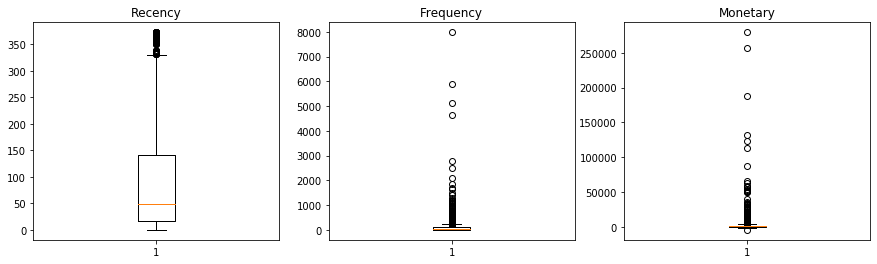

In [16]:
# Plotting the boxplot to check Outliers
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,4))
ax1.boxplot(rfm.Recency)
ax1.set_title('Recency')
ax2.boxplot(rfm.Frequency)
ax2.set_title('Frequency')
ax3.boxplot(rfm.Monetary)
ax3.set_title('Monetary')
plt.show()

In [17]:
#Statistical Summary
rfm.describe()

,CustomerID,Recency,Frequency,Monetary
count,4372.000000,4372.000000,4372.000000,4372.000000
mean,15299.677722,91.047118,93.053294,1898.459701
std,1722.390705,100.765435,232.471608,8219.345141
min,12346.000000,0.000000,1.000000,-4287.630000
25%,13812.750000,16.000000,17.000000,293.362500
50%,15300.500000,49.000000,42.000000,648.075000
75%,16778.250000,142.000000,102.000000,1611.725000
max,18287.000000,373.000000,7983.000000,279489.020000


There are two types of Outliers
- Statistical
- Domain Specific

Certain data points in Recency, Frequency and Monetary are Statistical Outliers however a domain expert may want them to be considered as they may make business sense.

It is advised to consult a domain expert in real life scenario. However we will cap the data leaving out extreame outliers on either sides

In [18]:
# removing (statistical) outliers in Monetary
Q1=rfm.Monetary.quantile(0.05)
Q3=rfm.Monetary.quantile(0.95)
IQR=Q3-Q1
rfm = rfm[(rfm.Monetary >= Q1 - 1.5*IQR) & (rfm.Monetary <= Q3 + 1.5*IQR)]

# removing (statistical) outliers in Frequency
Q1=rfm.Frequency.quantile(0.05)
Q3=rfm.Frequency.quantile(0.95)
IQR=Q3-Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

# removing (statistical) outliers in Recency
Q1=rfm.Recency.quantile(0.05)
Q3=rfm.Recency.quantile(0.95)
IQR=Q3-Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

In [19]:
# Lets drop CustomerID
rfm=rfm.drop('CustomerID',axis=1)
rfm.head()

,Recency,Frequency,Monetary
0,325,2,0.00
1,1,182,4310.00
2,74,31,1797.24
3,18,73,1757.55
4,309,17,334.40


Now we have a clean data free of missing values and Outliers. We shall scale the data.

#### Scaling of the Data

In [20]:
#Importing Standard Scaler
import sklearn
from sklearn.preprocessing import StandardScaler

# instantiating Scaler
scaler=StandardScaler()

# Fitting the data
rfm_scaled=scaler.fit_transform(rfm)

# Convert array to DataFrame
rfm_scaled=pd.DataFrame(rfm_scaled)
rfm_scaled.columns=['Recency','Frequency','Monetary']
rfm_scaled.head()

,Recency,Frequency,Monetary
0,2.301611,-0.752888,-0.723738
1,-0.906466,1.042467,1.731617
2,-0.183658,-0.463636,0.300128
3,-0.738141,-0.044720,0.277517
4,2.143188,-0.603275,-0.533235


Now we have clean data to start Modelling. We will explore both KMeans and Hierarchial clustering 

## 4. Modelling - K-Means Clustering

In [21]:
#Importing important libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

The important part of K-Means Clustering is deciding number of clusters. In a real life scenario we could consult domain experts to decide the number of clusters that make business sense.

However, other means of finding the optimal number of clusters are
- Elbow - Curve / SSD Method
- Silhouette Analysis

Even after finding optimal number of clusters using above methods we can consult domain experts to understand if it is good number.

Lets explore both these techniques

### Elbow - Curve / SSD Method

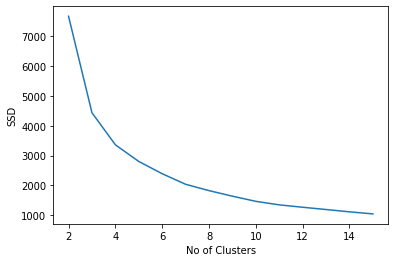

In [22]:
# Calculating SSDs for range of clusters
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8,9,10,11,12,13,14,15]
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, max_iter=100)
    kmeans.fit(rfm_scaled)
    
    ssd.append(kmeans.inertia_)
temp=pd.DataFrame(ssd,columns=['ssd'],index=range_n_clusters)

# plot the SSDs for each n_clusters
plt.plot(temp.ssd)
plt.xlabel('No of Clusters')
plt.ylabel('SSD')
plt.show()

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [23]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8,9,10,11,12,13,14,15]

for n_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=n_clusters, max_iter=100)
    kmeans.fit(rfm_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(n_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5389790406760827
For n_clusters=3, the silhouette score is 0.5084896296141937
For n_clusters=4, the silhouette score is 0.4816217519322445
For n_clusters=5, the silhouette score is 0.466103965297297
For n_clusters=6, the silhouette score is 0.417731425549664
For n_clusters=7, the silhouette score is 0.417451545753763
For n_clusters=8, the silhouette score is 0.40248429771636846
For n_clusters=9, the silhouette score is 0.414916162917348
For n_clusters=10, the silhouette score is 0.3792394844091928
For n_clusters=11, the silhouette score is 0.34510764419820195
For n_clusters=12, the silhouette score is 0.32381709403128917
For n_clusters=13, the silhouette score is 0.32569294887554495
For n_clusters=14, the silhouette score is 0.32063759734121244
For n_clusters=15, the silhouette score is 0.3296390928147893


**Observation:** SSD drops significantly from k(number of clusters)=2 to 3. and beyond 3 the drops arent significant. We can also see that silhouette score for k=3 is just over 0.5 and not much different from k=2. 2 number of clusters is quite low number to draw any insights. We will proceed with 3 number of clusters (k=3). However this decision should be taken in consultation with domain experts  
    

In [24]:
# K-Means model with k=3
kmeans = KMeans(n_clusters=3, max_iter=100)
kmeans.fit(rfm_scaled)

KMeans(max_iter=100, n_clusters=3)

In [25]:
# Lets store the Cluster IDs from K-Means in rfm dataframe
rfm['KMeansClusters']=kmeans.labels_
rfm.head()

,Recency,Frequency,Monetary,KMeansClusters
0,325,2,0.00,2
1,1,182,4310.00,1
2,74,31,1797.24,0
3,18,73,1757.55,0
4,309,17,334.40,2


### Insights

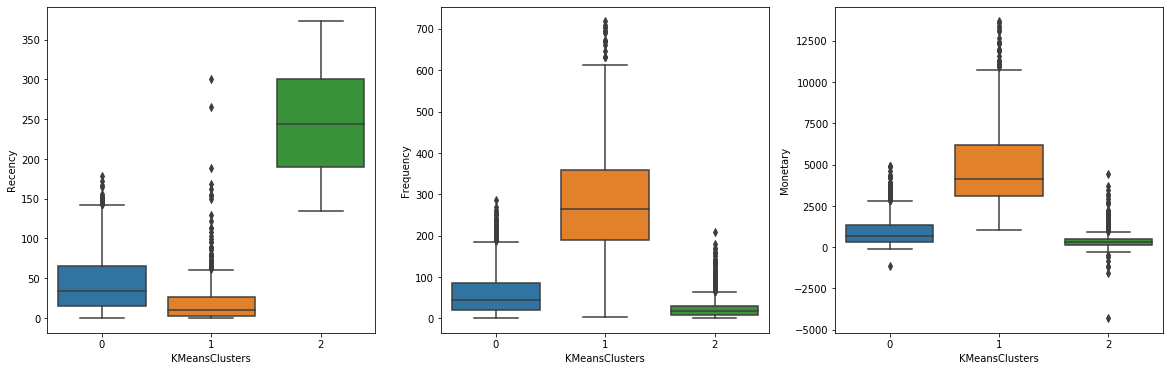

In [26]:
# Plotting the boxplot to check Outliers
fig,axes=plt.subplots(1,3,figsize=(20,6))
sns.boxplot(ax=axes[0],x='KMeansClusters',y='Recency',data=rfm)
sns.boxplot(ax=axes[1],x='KMeansClusters',y='Frequency',data=rfm)
sns.boxplot(ax=axes[2],x='KMeansClusters',y='Monetary',data=rfm)
plt.show()

**Insights:**
- Customers in Cluster 2 have purchased long back(mean of around 250 days). They are also less frequent and spent less money. Customers in this cluster are least valuable customers
- Customers in Cluster 1 on the other hand have purchased recently (mean of around 20 days). They are more frequent buyers and also spent more than other customers. Thus customers in the Cluster 1 are more valuable customers for the company.
- Customers in Cluster 0 are recent buyers but are less frequent and spent less money in shopping.

### Hierarchical Clustering

Now lets explore Hierarchial Clustering. We can use Complete Linkage method

In [27]:
# Import Necessary Libraries
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

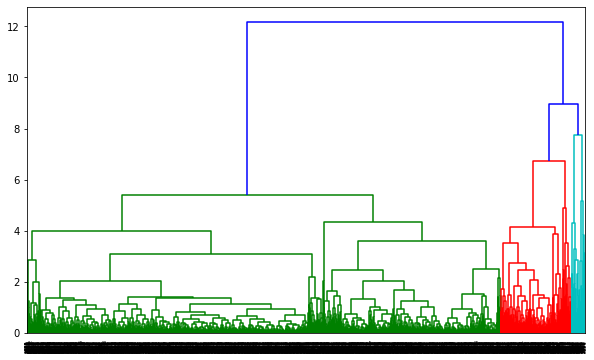

In [28]:
# complete linkage
mergings = linkage(rfm_scaled, method="complete", metric='euclidean')
plt.figure(figsize=(10,6))
dendrogram(mergings)
plt.show()

Seeing the dendogram we can cut the tree at cluster 3 level

In [29]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )

# Lets store the Cluster IDs from Hierarchial Clustering in rfm dataframe
rfm['HierarchialClusters']=cluster_labels
rfm.head()

,Recency,Frequency,Monetary,KMeansClusters,HierarchialClusters
0,325,2,0.00,2,0
1,1,182,4310.00,1,1
2,74,31,1797.24,0,0
3,18,73,1757.55,0,0
4,309,17,334.40,2,0


### Insights

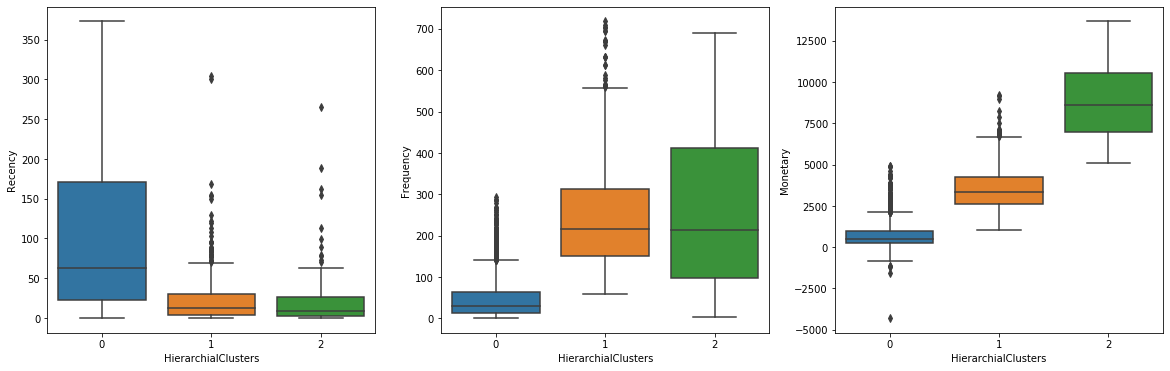

In [30]:
# Plotting the boxplot to check Outliers
fig,axes=plt.subplots(1,3,figsize=(20,6))
sns.boxplot(ax=axes[0],x='HierarchialClusters',y='Recency',data=rfm)
sns.boxplot(ax=axes[1],x='HierarchialClusters',y='Frequency',data=rfm)
sns.boxplot(ax=axes[2],x='HierarchialClusters',y='Monetary',data=rfm)
plt.show()

**Insights:**
- Customers in Cluster 0 have purchased long back(high Recency). They are also less frequent and spent less money compared to other Clusters. Customers in this cluster are least valuable customers
- Customers in Cluster 2 on the other hand have purchased recently (mean of around 20 days). They are more frequent buyers and also spent considerably more than other customers. Thus customers in the Cluster 2 are more valuable customers for the company.
- Customers in Cluster 1 are recent buyers and are also frequent but spent comparitively less money in shopping.